<a href="https://colab.research.google.com/github/edofreeg/emotoins-recognition/blob/main/deep_learning_emotion_rec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#A comparison between two CNN architectures for recognizing emotions


### Pietro Belussi and Edoardo Frigerio 

Dataset: https://www.kaggle.com/ananthu017/emotion-detection-fer

In this task, it will be tried to build the best architecture to analyze an image classification dataset that contains 35685 instances of 48x48 pixel gray scale images, already splitted into train and test datasets.

The target is to classify those images into 7 different classes that correspond to different emotions based on the facial expression: 



*   Happiness
*   Neutral
*   Sadness
*   Anger
*   Surprise
*   Disgust
*   Fearful

The two models that we are going to apply are two convolutional neural network architectures:



*   ResNet
*   A model based on the GoogleNet, with a different size of the zero-padding: in particular, given the padding size (Pₕ , Pₖ) and the kernel (or filter) size (Kₕ , Kₖ), the padding is computed as: Pₕ = Kₕ - 1 and Pₖ = Kₖ - 1.

After having implemented the two CNNs, we will focus on the Accuracy and the Loss Function metrics to compare the two architectures and discuss which is the best one. 













###Imports

In [ ]:
import cv2
import os
import shutil
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import zipfile
from google.colab import files
%matplotlib inline
import plotly.express as px

###Data loading: importing image dataset from Kaggle 

In [ ]:
uploaded = files.upload()

In [ ]:
os.environ["KAGGLE_CONFIG_DIR"]="/content"

In [ ]:
!kaggle datasets download -d ananthu017/emotion-detection-fer

In [ ]:
zip_ref= zipfile.ZipFile("emotion-detection-fer.zip","r")
zip_ref.extractall("/content")
zip_ref.close()

In [ ]:
# Looking into the directory
data_dir =  "/content"
classes_train = os.listdir(data_dir + "/train")
classes_test = os.listdir(data_dir + "/test")

In [ ]:
# Data transforms (Gray Scaling & data augmentation)
train_tfms = tt.Compose([tt.Grayscale(num_output_channels=1),
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(0),
                         tt.ToTensor()])

test_tfms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.ToTensor()])

In [ ]:
# Emotion Detection datasets
train_ds = ImageFolder(data_dir + '/train', train_tfms)
test_ds = ImageFolder(data_dir + '/test', test_tfms)

In [ ]:
batch_size = 200

In [ ]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=3, pin_memory=True)

###Data visualization

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



torch.Size([1, 48, 48])


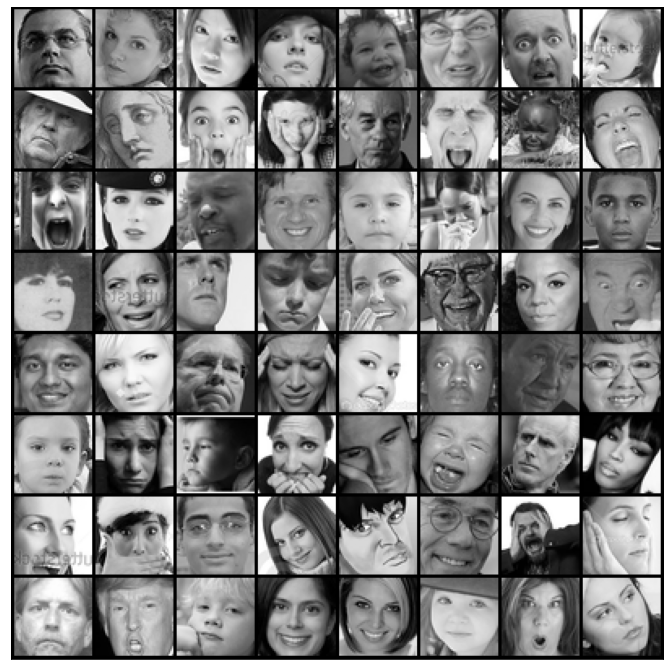

In [ ]:
show_batch(train_dl) #show some images of the train dataset

###Data exploration


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

In [ ]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = "train",
                                                    target_size = (48 ,48),
                                                    batch_size = 64,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )
test_generator = test_datagen.flow_from_directory(directory = "test",
                                                   target_size = (48 ,48),
                                                    batch_size = 64,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

In [ ]:
labels_train= ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']

In [ ]:
def display_nine_images(images, titles, title_colors=None):
    subplot = 331
    plt.figure(figsize=(7,7))
    for i in range(9):
        color = 'black' if title_colors is None else title_colors[i]
        display_one_image(images[i], titles[i], 331+i, color)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def display_one_image(image, title, subplot, color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16)
    
img_datagen = ImageDataGenerator(rescale = 1./255)
img_generator = img_datagen.flow_from_directory(directory = "train",
                                                   target_size = (48 ,48),
                                                    batch_size = 64,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

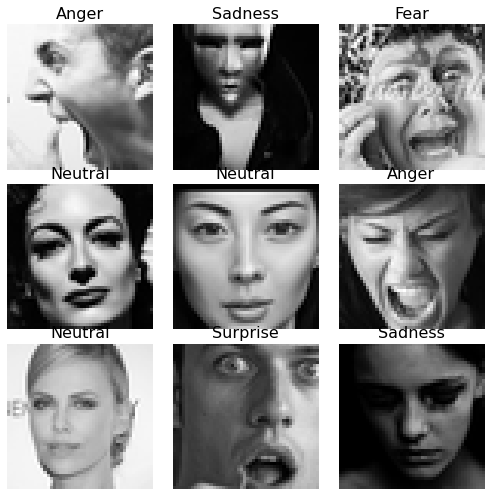

In [ ]:
images, classes = next(img_generator) #emotion visualization
class_idxs = np.argmax(classes, axis=-1) 
labels = [labels_train[idx] for idx in class_idxs]
display_nine_images(images, labels)

In [ ]:
fig = px.bar(x = labels_train,
             y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)], 
             color = np.unique(train_generator.classes)) 
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [ ]:
fig = px.bar(x = labels_train,
             y = [list(test_generator.classes).count(i) for i in np.unique(test_generator.classes)] , 
             color = np.unique(test_generator.classes) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Test Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

###Implementing the first architecture: ResNet

---



In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
device = get_default_device()

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

Training steps creation

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss 
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

Model creation

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ELU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet(1, len(classes_train)), device)
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

Training model


In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, test_dl)]

In [ ]:
epochs = 70
max_lr = 0.008
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, test_dl, 
                        grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



Epoch [0], last_lr: 0.00036, train_loss: 1.8678, val_loss: 1.5008, val_acc: 0.4318
Epoch [1], last_lr: 0.00049, train_loss: 1.5018, val_loss: 1.4238, val_acc: 0.4520
Epoch [2], last_lr: 0.00070, train_loss: 1.4133, val_loss: 1.3494, val_acc: 0.4945
Epoch [3], last_lr: 0.00099, train_loss: 1.3498, val_loss: 1.3216, val_acc: 0.5084
Epoch [4], last_lr: 0.00134, train_loss: 1.3232, val_loss: 1.2816, val_acc: 0.5009
Epoch [5], last_lr: 0.00176, train_loss: 1.3041, val_loss: 1.2306, val_acc: 0.5409
Epoch [6], last_lr: 0.00224, train_loss: 1.2858, val_loss: 1.2265, val_acc: 0.5261
Epoch [7], last_lr: 0.00275, train_loss: 1.3425, val_loss: 1.3828, val_acc: 0.4487
Epoch [8], last_lr: 0.00330, train_loss: 1.3681, val_loss: 1.3270, val_acc: 0.4755
Epoch [9], last_lr: 0.00387, train_loss: 1.3541, val_loss: 1.3790, val_acc: 0.4457
Epoch [10], last_lr: 0.00445, train_loss: 1.3690, val_loss: 1.3482, val_acc: 0.4842
Epoch [11], last_lr: 0.00501, train_loss: 1.3082, val_loss: 1.5671, val_acc: 0.3902
Ep

Checking performance


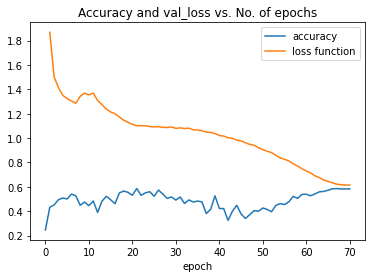

In [ ]:
def plot_accuracies_val_loss(history):
    accuracies = [x['val_acc'] for x in history]
    val_loss = [x.get("train_loss") for x in history]
    plt.plot(accuracies ,label='accuracy')
    plt.plot(val_loss,label="loss function")
    plt.xlabel('epoch')
    plt.title('Accuracy and val_loss vs. No. of epochs')
    leg = plt.legend()

plot_accuracies_val_loss(history)

In [ ]:
#final accuracy after 70 epochs
accuracies = [x['val_acc'] for x in history][-1]
accuracies 

0.58418208360672

In [ ]:
# final validation loss after 70 epochs
train_loss = [x.get("train_loss") for x in history][-1]
train_loss 

0.614651620388031

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

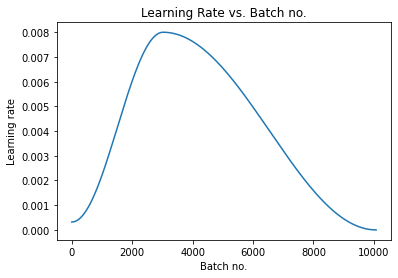

In [ ]:
#adaptive learning rate
plot_lrs(history)

###Applying the second model: modified GoogleNet




In [ ]:
pip install d2l

In [ ]:
from d2l import torch as d2l
import torch
from torch import nn
from torch.nn import functional as F

In [ ]:


class Inception(nn.Module):
    # `c1`--`c4` are the number of output channels for each path
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs): #192, 64, (96, 128), (16, 32), 32)
        super(Inception, self).__init__(**kwargs)
        # Path 1 is a single 1 x 1 convolutional layer
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # Path 2 is a 1 x 1 convolutional layer followed by a 3 x 3
        # convolutional layer
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # Path 3 is a 1 x 1 convolutional layer followed by a 5 x 5
        # convolutional layer
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # Path 4 is a 3 x 3 maximum pooling layer followed by a 1 x 1
        # convolutional layer
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # Concatenate the outputs on the channel dimension
        return torch.cat((p1, p2, p3, p4), dim=1)

In [ ]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=4,padding=1 ),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 7))

In [ ]:
X = torch.rand(size=(1, 1, 48, 48))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 7])


loss 0.436, train acc 0.844, test acc 0.594
439.3 examples/sec on cuda:0


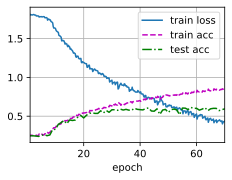

In [ ]:
lr, num_epochs, batch_size = 0.5, 70, 128
model=d2l.train_ch6(net, train_dl, test_dl, num_epochs, lr, device=d2l.try_gpu())